In [1]:
!git clone https://github.com/TUIlmenauAMS/Python-Audio-Coder 
%cd Python-Audio-Coder
%reset -f

fatal: destination path 'Python-Audio-Coder' already exists and is not an empty directory.
/Users/kyungyunlee/dev/tp-evaluation/metrics/Python-Audio-Coder


In [2]:
import os
import pandas as pd
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import psyacloss
import torch
import auraloss
from collections import defaultdict
import pprint 
import matplotlib.gridspec as gridspec
import scipy
import matplotlib as mpl
import seaborn as sns


import sys
sys.path.append("/Users/kyungyunlee/dev/tp-evaluation")
print (sys.path)
from DecayFitNet.python.toolbox.DecayFitNetToolbox import DecayFitNetToolbox
from DecayFitNet.python.toolbox.core import discard_last_n_percent, decay_model, PreprocessRIR
from rir_similarity_metrics.metrics import * 

text_width = 7.16
column_width = 3.15

font = {'family' : 'Times New Roman',
        'size'   : 9}
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)
mpl.rc('font', **font)
plt.rcParams['text.latex.preamble'] = r"\usepackage{siunitx} \sisetup{detect-all} \usepackage{helvet} \usepackage{sansmath} \sansmath"   


['/Users/kyungyunlee/miniconda3/envs/avar2024/lib/python311.zip', '/Users/kyungyunlee/miniconda3/envs/avar2024/lib/python3.11', '/Users/kyungyunlee/miniconda3/envs/avar2024/lib/python3.11/lib-dynload', '', '/Users/kyungyunlee/miniconda3/envs/avar2024/lib/python3.11/site-packages', '/Users/kyungyunlee/dev/tp-evaluation', './PythonPsychoacoustics', '/Users/kyungyunlee/dev/tp-evaluation']


In [3]:
FS = 48000
DIR = "/Users/kyungyunlee/dev/tp-evaluation"

In [4]:

def find_direct_location(rir):
    peak_val = np.max(np.abs(rir))
    peak_val_location = np.argmax(np.abs(rir))
    threshold_val = 10**(-1/2)  * peak_val 
    candidate_list = np.argwhere(np.array(rir[:peak_val_location])> threshold_val)
    if len(candidate_list) == 0 :
        return peak_val_location
    else : 
        direct_location = candidate_list[0][0]
        return direct_location 


def process_rir(rir, sr) : 
    # Cut out or pad beginning part if needed 
    # 20 ms 
    frontal_silence_length = int(sr*0.003)
    direct_location = find_direct_location(rir)
    
    if direct_location < frontal_silence_length : 
        # pad 
        pad_length = frontal_silence_length - direct_location
        rir_processed = np.zeros((len(rir) + pad_length,))
        rir_processed[pad_length: ] = rir 
    else : 
        # trim 
        rir_processed = rir[direct_location - frontal_silence_length:]
    return rir_processed 


def get_decayfitnet_params(rir, fs, filter_frequencies) : 
    # filter_frequencies = [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000]
    n_slopes = 1

    # Prepare the model
    decayfitnet = DecayFitNetToolbox(n_slopes=n_slopes, sample_rate=fs, filter_frequencies=filter_frequencies)

    # Process: analyse_full_rir: if RIR onset should be detected, set this to False
    estimated_parameters_decayfitnet, norm_vals = decayfitnet.estimate_parameters(rir, analyse_full_rir=True)
    [T,A,noise] = estimated_parameters_decayfitnet
    T = T[:, 0]
    A = A[:, 0]
    noise = noise[:, 0]

    return T, A, noise, norm_vals

In [5]:
rir_df = pd.read_csv(f"/Users/kyungyunlee/dev/tp-evaluation/rir_list.csv", delimiter=",")

In [6]:
models =["rt2rir", "rt2rir_direct_only", "echo_density", "fdn", "fins", "dark_velvet_noise"] 
rir_df = pd.read_csv(f"/Users/kyungyunlee/dev/tp-evaluation/rir_list.csv", delimiter=",")
rir_df.sort_values(by=['rt'])
rir_filenames = [f.split(".")[0] for f  in list(rir_df["filename"])]
print (rir_filenames)



# result_files = list(Path("/Users/kyungyunlee/dev/webMUSHRA/results/").rglob("tp_eval_pid*/3AFC.csv"))
result_files = [f"/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid{n}/3AFC.csv" for n in range(10,30)]
print(result_files)

df = None
for result_file in result_files : 
    _df = pd.read_csv(result_file)
    df = pd.concat([df, _df], ignore_index=True)

sameSpk_model_numCorrect = []
diffSpk_model_numCorrect = [] 
model_percentage_per_pid = [] 
numCorrect_per_room_samesame = [] 
numCorrect_per_room_diffdiff = [] 

participant_ids = list(set(list(df["participantId"])))
print(participant_ids)

for model in models : 
    model_df = df[df['trial_id'].str.contains(f"{model}.wav")]
    # print (model_df)

    # Overall 
    # overall_num_correct = len(model_df[model_df["choice_answer"] == "correct"])
    # overall_percentage_correct = overall_num_correct / len(model_df) * 100
    # print (model, overall_percentage_correct)
    # model_percentage.append(overall_percentage_correct)

    # Same same 
    same_df = model_df[model_df["trial_id"].str.contains("sameSpk")]
    same_num_correct = len(same_df[same_df["choice_answer"] == "correct"])
    same_num_incorrect = len(same_df[same_df["choice_answer"] == "incorrect"])
    # same_percentage_correct = same_num_correct / len(same_df) * 100
    sameSpk_model_numCorrect.append([same_num_correct, same_num_incorrect ])
    
    # Diff diff 
    diff_df = model_df[model_df["trial_id"].str.contains("diffSpk")]
    diff_num_correct = len(diff_df[diff_df["choice_answer"] == "correct"])
    diff_num_incorrect = len(diff_df[diff_df["choice_answer"] == "incorrect"])
    # diff_percentage_correct = diff_num_correct / len(diff_df) * 100
    diffSpk_model_numCorrect.append([diff_num_correct,diff_num_incorrect])

#     # Per person 
#     per_person_percentage_correct = [] 
#     # num_correct_test2 = 0 
#     for pid in participant_ids : 
#         model_pid_df = model_df[model_df["participantId"] == pid]
#         num_correct = len(model_pid_df[model_pid_df["choice_answer"] == "correct"])
#         # num_correct_test2 += num_correct
#         percentage_correct = num_correct / len(model_pid_df) * 100
#         per_person_percentage_correct.append(percentage_correct) 
#     model_percentage_per_pid.append(per_person_percentage_correct)



    # Per RIR
    per_rir_numCorrect_samesame = [] 
    per_rir_numCorrect_diffdiff = [] 

    for rir_file in rir_filenames : 
        # Same same 
        model_rir_df = same_df[same_df["trial_id"].str.contains(rir_file)]
        num_correct = len(model_rir_df[model_rir_df["choice_answer"] == "correct"])
        num_incorrect = len(model_rir_df[model_rir_df["choice_answer"] == "incorrect"])
       
        per_rir_numCorrect_samesame.append([num_correct,num_incorrect]) 

        # diff diff 
        model_rir_df = diff_df[diff_df["trial_id"].str.contains(rir_file)]
        num_correct = len(model_rir_df[model_rir_df["choice_answer"] == "correct"])
        num_incorrect = len(model_rir_df[model_rir_df["choice_answer"] == "incorrect"])
       
       
        per_rir_numCorrect_diffdiff.append([num_correct,num_incorrect])
        

    
    numCorrect_per_room_samesame.append(per_rir_numCorrect_samesame)
    numCorrect_per_room_diffdiff.append(per_rir_numCorrect_diffdiff)                                               
    # print(num_correct_test2, num_correct_test, overall_num_correct)

['h110_Office_MeetingRoom_1txts', 'h001_Bedroom_65txts', 'h027_Classroom_8txts', 'h163_Bathroom_1txts', 'h229_Office_Lobby_1txts', 'h025_Diningroom_8txts', 'h042_Hallway_ElementarySchool_4txts']
['/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid10/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid11/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid12/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid13/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid14/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid15/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid16/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid17/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid18/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid19/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid20/3AFC.csv', '/Users/kyungyunlee/dev/webMUSHRA/results/tp_eval_pid21/3AFC.csv', 

In [8]:
samesame_per_room = numCorrect_per_room_samesame
diffdiff_per_room = numCorrect_per_room_diffdiff

samesame_per_room = np.array([[i[0] / sum(i) for i in room] for room in samesame_per_room])
diffdiff_per_room = np.array([[i[0] / sum(i) for i in room] for room in diffdiff_per_room])

print (samesame_per_room)
print (samesame_per_room.shape)

[[0.75 0.8  0.9  0.4  1.   0.95 0.65]
 [0.95 1.   0.8  0.95 1.   1.   1.  ]
 [0.85 1.   0.9  0.95 1.   1.   0.85]
 [0.75 0.85 0.85 0.85 0.9  0.85 1.  ]
 [0.85 0.95 0.95 1.   0.95 0.9  1.  ]
 [0.65 0.4  0.45 0.5  0.95 0.35 0.95]]
(6, 7)


In [9]:
mrstft = auraloss.freq.MultiResolutionSTFTLoss()

models =["rt2rir", "rt2rir_direct_only", "echo_density", "fdn", "fins", "dark_velvet_noise"] 
loss_types = ["mse", "multi_stft", "ploss"]
rir_filenames = list(rir_df["filename"])

loss_matrix = np.zeros((len(models), len(rir_filenames), len(loss_types)))

loss_dict = {} 

for model_index, model in enumerate(models) : 
    loss_dict[model] = {} 
    for rir_index, series in rir_df.iterrows() : 
        path, filename, rt, real  = series
        
        original_rir_file = Path(DIR) / path / filename
        generated_rir_file = Path(DIR) / "models" / model / "result" / filename
    
        original_rir, _ = librosa.load(original_rir_file, sr=FS)
        original_rir = process_rir(original_rir, FS) 
    
        generated_rir, _ = librosa.load(generated_rir_file, sr=FS)
        generated_rir = process_rir(generated_rir, FS) 

        if generated_rir.shape != original_rir.shape : 
            print ("Shape not matching")
            
            if generated_rir.shape[0] > original_rir.shape[0]: 
                generated_rir = generated_rir[:original_rir.shape[0]]
            else : 
                generated_rir_tmp = np.zeros_like(original_rir)
                generated_rir_tmp[ :generated_rir.shape[0]] = generated_rir
                generated_rir = generated_rir_tmp

    
        mse = np.mean((original_rir - generated_rir)**2)
         
        # multi stft
        multi_stft_loss = mrstft(torch.from_numpy(original_rir).unsqueeze(0).unsqueeze(0), torch.from_numpy(generated_rir).unsqueeze(0).unsqueeze(0))
        
        # Average power 
        avg_power_loss = AveragePower()
        
        
        filter_frequencies = [250, 500, 1000, 2000, 4000, 8000]
        original_decay_params = get_decayfitnet_params(original_rir, FS, filter_frequencies) 
        generated_decay_params = get_decayfitnet_params(generated_rir, FS, filter_frequencies) 
        original_rt = np.mean(original_decay_params[0])
        generated_rt = np.mean(generated_decay_params[0])

    
        # pychoacoustic loss 
        speech_files = [] 
        for speaker_id in range(1, 22) : 
            speech_files = ["/Users/kyungyunlee/dev/tp-evaluation/datasets/speech/audio_exports_Harvard_Sets_Cleaned_Extended/P5 - Set 1 - 4.wav"]
            speech_file_list = list(Path("/Users/kyungyunlee/dev/tp-evaluation/datasets/speech/audio_exports_Harvard_Sets_Cleaned_Extended/").glob(f"P{speaker_id} - *.wav"))
            speech_file = np.random.choice(speech_file_list)
            speech_files.append(speech_file) 
            
        avg_ploss = 0.0
        avg_speech_mse_loss = 0.0
        avg_speech_stft_loss = 0.0
        avg_speech_power_loss = 0.0
        avg_speech_edc_loss = 0.0 
        
        for speech_file in speech_files: 
            speech, _ = librosa.load(speech_file, sr=FS)
            original_rir_speech = scipy.signal.fftconvolve(speech, original_rir)
            generated_rir_speech = scipy.signal.fftconvolve(speech, generated_rir)
            
            ploss = psyacloss.percloss(original_rir_speech, generated_rir_speech, FS)
            avg_ploss += ploss 
            
            speech_mse = np.mean((original_rir_speech - generated_rir_speech)**2)
            speech_stft = mrstft(torch.from_numpy(original_rir_speech).unsqueeze(0).unsqueeze(0), torch.from_numpy(generated_rir_speech).unsqueeze(0).unsqueeze(0))
            
            speech_avg_power = avg_power_loss(torch.from_numpy(original_rir_speech).unsqueeze(0).unsqueeze(0).float(), torch.from_numpy(generated_rir_speech).unsqueeze(0).unsqueeze(0).float())           
            
            avg_speech_mse_loss += speech_mse
            avg_speech_stft_loss += speech_stft.item() 
            avg_speech_power_loss += speech_avg_power.item() 

            
    
        avg_ploss /= len(speech_files) 
        avg_speech_mse_loss /= len(speech_files) 
        avg_speech_stft_loss /= len(speech_files) 
        avg_speech_power_loss /= len(speech_files)

        loss_matrix[model_index][rir_index][loss_types.index("mse")] = avg_speech_mse_loss 
        loss_matrix[model_index][rir_index][loss_types.index("multi_stft")] = avg_speech_stft_loss
        loss_matrix[model_index][rir_index][loss_types.index("ploss")] = avg_ploss 

        loss_dict[model][filename] = {}
        loss_dict[model][filename]["mse"] = mse
        loss_dict[model][filename]["multi_stft"] = multi_stft_loss.item()
        loss_dict[model][filename]["ploss"] = avg_ploss
        loss_dict[model][filename]["speech_mse"] = avg_speech_mse_loss
        loss_dict[model][filename]["speech_stft"] = avg_speech_stft_loss

        
        loss_dict[model][filename]["listening_test_samesame"] = samesame_per_room[model_index][rir_index]
        loss_dict[model][filename]["listening_test_diffdiff"] = diffdiff_per_room[model_index][rir_index]
        
        


/Users/kyungyunlee/miniconda3/envs/avar2024/lib/python3.11/site-packages/torch/functional.py:660: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:843.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


Shape not matching
Shape not matching


In [10]:
loss_df = pd.concat({k: pd.DataFrame(v).T for k, v in loss_dict.items()}, axis=0)
loss_df

mse  \
rt2rir             h110_Office_MeetingRoom_1txts.wav        0.000011   
                   h001_Bedroom_65txts.wav                  0.000013   
                   h027_Classroom_8txts.wav                 0.000014   
                   h163_Bathroom_1txts.wav                  0.000011   
                   h229_Office_Lobby_1txts.wav              0.000006   
                   h025_Diningroom_8txts.wav                0.000006   
                   h042_Hallway_ElementarySchool_4txts.wav  0.000018   
rt2rir_direct_only h110_Office_MeetingRoom_1txts.wav        0.000181   
                   h001_Bedroom_65txts.wav                  0.000113   
                   h027_Classroom_8txts.wav                 0.000068   
                   h163_Bathroom_1txts.wav                  0.000347   
                   h229_Office_Lobby_1txts.wav              0.000047   
                   h025_Diningroom_8txts.wav                0.000025   
                   h042_Hallway_ElementarySchool_4txts.wav  0.000074   
echo_density       h110_Office_MeetingRoom_1txts.wav        0.000110   
                   h001_Bedroom_65txts.wav                  0.000064   
                   h027_Classroom_8txts.wav                 0.000061   
                   h163_Bathroom_1txts.wav                  0.000311   
                   h229_Office_Lobby_1txts.wav              0.000037   
                   h025_Diningroom_8txts.wav                0.000021   
                   h042_Hallway_ElementarySchool_4txts.wav  0.000075   
fdn                h110_Office_MeetingRoom_1txts.wav        0.000109   
                   h001_Bedroom_65txts.wav                  0.000055   
                   h027_Classroom_8txts.wav                 0.000058   
                   h163_Bathroom_1txts.wav                  0.000509   
                   h229_Office_Lobby_1txts.wav              0.000031   
                   h025_Diningroom_8txts.wav                0.000014   
                   h042_Hallway_ElementarySchool_4txts.wav  0.000116   
fins               h110_Office_MeetingRoom_1txts.wav        0.000067   
                   h001_Bedroom_65txts.wav                  0.000041   
                   h027_Classroom_8txts.wav                 0.000041   
                   h163_Bathroom_1txts.wav                  0.000314   
                   h229_Office_Lobby_1txts.wav              0.000058   
                   h025_Diningroom_8txts.wav                0.000025   
                   h042_Hallway_ElementarySchool_4txts.wav  0.000101   
dark_velvet_noise  h110_Office_MeetingRoom_1txts.wav        0.000007   
                   h001_Bedroom_65txts.wav                  0.000006   
                   h027_Classroom_8txts.wav                 0.000007   
                   h163_Bathroom_1txts.wav                  0.000017   
                   h229_Office_Lobby_1txts.wav              0.000030   
                   h025_Diningroom_8txts.wav                0.000003   
                   h042_Hallway_ElementarySchool_4txts.wav  0.000023   

                                                            multi_stft  \
rt2rir             h110_Office_MeetingRoom_1txts.wav          0.535561   
                   h001_Bedroom_65txts.wav                    0.755344   
                   h027_Classroom_8txts.wav                   0.487007   
                   h163_Bathroom_1txts.wav                    0.525825   
                   h229_Office_Lobby_1txts.wav                0.620364   
                   h025_Diningroom_8txts.wav                  0.615775   
                   h042_Hallway_ElementarySchool_4txts.wav    0.706869   
rt2rir_direct_only h110_Office_MeetingRoom_1txts.wav          0.933919   
                   h001_Bedroom_65txts.wav                    1.138945   
                   h027_Classroom_8txts.wav                   0.762805   
                   h163_Bathroom_1txts.wav                    1.406575   
                   h229_Office_Lobby_1txts.wav                0.961259   
      

In [11]:
for loss in loss_types : # = ["mse", "multi_stft", "ploss"]
    print (loss)
    same_stats=  scipy.stats.pearsonr(loss_df[loss], loss_df['listening_test_samesame'])
    diff_stats= scipy.stats.pearsonr(loss_df[loss], loss_df['listening_test_diffdiff'])
    same_corrcoef = np.corrcoef(loss_df[loss], loss_df['listening_test_samesame'])
    print (same_stats)
    print (same_corrcoef)
    print (diff_stats)

mse
PearsonRResult(statistic=0.26949737425212555, pvalue=0.08436020338826275)
[[1.         0.26949737]
 [0.26949737 1.        ]]
PearsonRResult(statistic=0.3495991231778575, pvalue=0.023242472034843607)
multi_stft
PearsonRResult(statistic=0.4504914058220994, pvalue=0.002755649375804573)
[[1.         0.45049141]
 [0.45049141 1.        ]]
PearsonRResult(statistic=0.47995359564952594, pvalue=0.0012976765568339546)
ploss
PearsonRResult(statistic=0.4392664735818137, pvalue=0.003609643161501119)
[[1.         0.43926647]
 [0.43926647 1.        ]]
PearsonRResult(statistic=0.4418926451902311, pvalue=0.003391440398202999)


In [13]:
scipy.stats.pearsonr(loss_df['ploss'], loss_df['listening_test_samesame'])

PearsonRResult(statistic=0.4392664735818137, pvalue=0.003609643161501119)

In [14]:
scipy.stats.pearsonr(loss_df['multi_stft'], loss_df['listening_test_diffdiff'])

PearsonRResult(statistic=0.47995359564952594, pvalue=0.0012976765568339546)

In [15]:
listening_test_corr = scipy.stats.pearsonr(loss_df['listening_test_samesame'], loss_df['listening_test_diffdiff'])
print(listening_test_corr)

PearsonRResult(statistic=0.6973276727658768, pvalue=2.8786511849090993e-07)


In [16]:
def adjusted_r_squared(x, y): 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    r_squared = r_value**2
    
    # Compute adjusted R^2
    n = len(y)  # Number of data points
    p = 1       # Number of predictors
    if n > p + 1:
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    else:
        adjusted_r_squared = None  # Undefined for n = p + 1
        
    return adjusted_r_squared, p_value
    

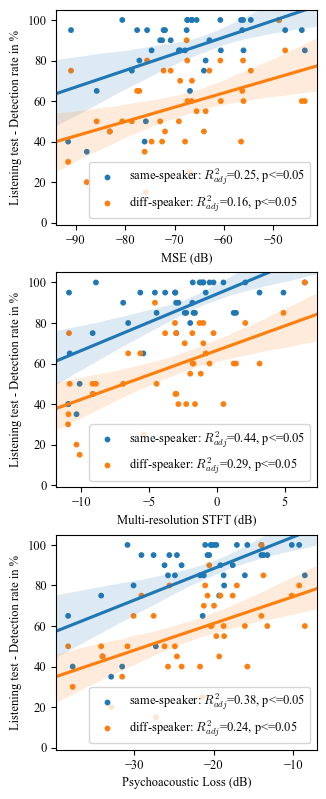

In [17]:
f, axes = plt.subplots(len(loss_types), 1 , figsize=(column_width, column_width*2.5), constrained_layout=True)

losses = ['speech_mse', 'speech_stft', 'ploss']
loss_labels = ['MSE', 'Multi-resolution STFT', 'Psychoacoustic Loss']

for i, (loss, loss_label) in enumerate(zip(losses, loss_labels)) : 
    
    s = [10 for n in range(len(loss_df['listening_test_samesame']))]
        
    same_adj_r, same_pval = adjusted_r_squared(20 * np.log10(loss_df[loss]), loss_df['listening_test_samesame'])
    diff_adj_r, diff_pval = adjusted_r_squared(20 * np.log10(loss_df[loss]), loss_df['listening_test_diffdiff'])

    if same_pval <= 0.05 : 
        axes[i].scatter(20 * np.log10(loss_df[loss]), loss_df['listening_test_samesame'] * 100, label=rf'same-speaker: $R_{{adj}}^2$={same_adj_r:.2f}, p<=0.05', s=s)
    else : 
        axes[i].scatter(20 * np.log10(loss_df[loss]), loss_df['listening_test_samesame'] * 100, label=rf'same-speaker: $R_{{adj}}^2$={same_adj_r:.2f}, p>0.05', s=s)
    
    if diff_pval <= 0.05 :
        axes[i].scatter(20 * np.log10 (loss_df[loss]), loss_df['listening_test_diffdiff'] * 100, label=rf'diff-speaker: $R_{{adj}}^2$={diff_adj_r:.2f}, p<=0.05', s=s)
    else :
        axes[i].scatter(20 * np.log10 (loss_df[loss]), loss_df['listening_test_diffdiff'] * 100 , label=rf'diff-speaker: $R_{{adj}}^2$={diff_adj_r:.2f}, p>0.05', s=s)
    axes[i].set_ylim([-1, 105])


    sns.regplot(x=20 * np.log10(loss_df[loss]), y=loss_df['listening_test_samesame']*100, truncate=False, ax=axes[i], scatter=False)
    sns.regplot(x=20*np.log10(loss_df[loss]), y=loss_df['listening_test_diffdiff']*100, truncate=False, ax=axes[i], scatter=False)
    axes[i].set_ylabel("")
    axes[i].set_xlabel(loss_label + " (dB)")
    axes[i].legend()
    

    axes[i].set_ylabel("Listening test - Detection rate in %")



plt.savefig(os.path.join(DIR, 'metrics/correlations.pdf'), format='pdf', bbox_inches='tight')


['h110_Office_MeetingRoom_1txts.wav', 'h001_Bedroom_65txts.wav', 'h027_Classroom_8txts.wav', 'h163_Bathroom_1txts.wav', 'h229_Office_Lobby_1txts.wav', 'h025_Diningroom_8txts.wav', 'h042_Hallway_ElementarySchool_4txts.wav']


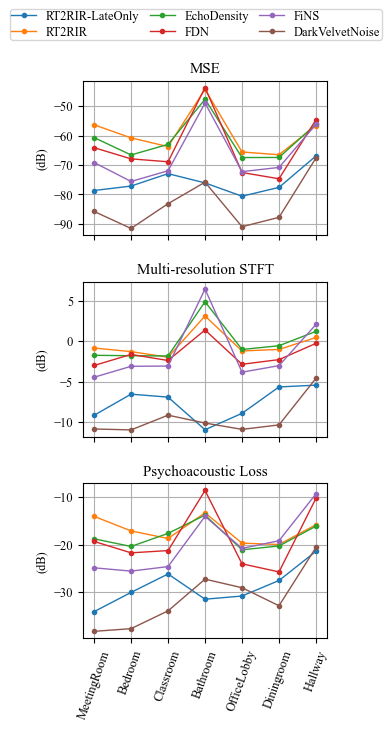

In [18]:
f, axes = plt.subplots(len(loss_types), 1 , figsize=(column_width, column_width*2.3))

model_labels = ["RT2RIR-LateOnly", "RT2RIR", "EchoDensity", "FDN", "FiNS", "DarkVelvetNoise"]
loss_labels = ["MSE", "Multi-resolution STFT", "Psychoacoustic Loss"]
rir_filenames_short = ["MeetingRoom", "Bedroom", "Classroom", "Bathroom", "OfficeLobby", "Diningroom", "Hallway"]

print (rir_filenames)
for loss_index, loss in enumerate(loss_types) : 

    
    axes[loss_index].plot(20 * np.log10 (loss_matrix[:, :, loss_types.index(loss)].swapaxes(0,1)) , marker='o', linewidth=1, markersize=3, label=model_labels)

    axes[loss_index].set_xticks(range(len(rir_filenames_short)), [])
    axes[loss_index].set_title(loss_labels[loss_index])
    axes[loss_index].grid()
    axes[loss_index].set_ylabel("(dB)")

    axes[2].set_xticks(range(len(rir_filenames_short)), [tokens for tokens in rir_filenames_short], rotation=70)

axes[0].legend(ncols=3, bbox_to_anchor=(1.25, 1.5),labelspacing=0.3,columnspacing=0.8, borderpad=0.1)

plt.subplots_adjust(
                   hspace=0.3)


plt.savefig(os.path.join(DIR, 'metrics/objective_metrics.pdf'), format='pdf', bbox_inches='tight')
